In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"seojinpark2001","key":"95969a26deff4513cc35a02c51ddd1a0"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning이 발생하지 않도록 해줍니다.
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c nyc-taxi-trip-duration

 93% 80.0M/85.8M [00:00<00:00, 109MB/s]
100% 85.8M/85.8M [00:00<00:00, 119MB/s]


In [4]:
!unzip nyc-taxi-trip-duration.zip

Archive:  nyc-taxi-trip-duration.zip
  inflating: sample_submission.zip   
  inflating: test.zip                
  inflating: train.zip               


In [5]:
!unzip train.zip
!unzip test.zip
!unzip sample_submission.zip

Archive:  train.zip
  inflating: train.csv               
Archive:  test.zip
  inflating: test.csv                
Archive:  sample_submission.zip
  inflating: sample_submission.csv   


## Import

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from datetime import datetime
import calendar
from math import sin, cos, sqrt, atan2, radians
from folium import FeatureGroup, LayerControl, Map, Marker
from folium.plugins import HeatMap
import matplotlib.dates as mdates
import matplotlib as mpl
from datetime import timedelta
import datetime as dt
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
plt.style.use('fivethirtyeight')
import folium
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import pickle

## Load Data

In [7]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

In [8]:
print(train.shape, test.shape)

(1458644, 11) (625134, 9)


## Exploratory Data Analysis

### **Convert to appropriate data type**

Convert pickup datetime and dropoff datetime into date-time object

In [9]:
train.dtypes

id                    object 
vendor_id             int64  
pickup_datetime       object 
dropoff_datetime      object 
passenger_count       int64  
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag    object 
trip_duration         int64  
dtype: object

In [10]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'], format = '%Y-%m-%d %H:%M:%S')
train['dropoff_datetime'] = pd.to_datetime(train['dropoff_datetime'], format = '%Y-%m-%d %H:%M:%S')

train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


#### Are there any missing values in the data?

In [11]:
train.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

There are no missing values

#### What is the time period of the dataset?

In [12]:
print("Min pickup time: ", min(train['pickup_datetime']))
print("Max pickup time: ", max(train['pickup_datetime']))

Min pickup time:  2016-01-01 00:00:17
Max pickup time:  2016-06-30 23:59:39


The data has 6 months of taxi trip data, from Jan to Jun 2016.

#### Create new day, month, hour info from pickup time

In [13]:
train['pickup_date'] = train['pickup_datetime'].dt.date
train['pickup_day'] = train['pickup_datetime'].apply(lambda x: x.day)
train['pickup_hour'] = train['pickup_datetime'].apply(lambda x: x.hour)
train['pickup_day_of_week'] = train['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
train['dropoff_date'] = train['dropoff_datetime'].dt.date
train['dropoff_day'] = train['dropoff_datetime'].apply(lambda x:x.day)
train['dropoff_hour'] = train['dropoff_datetime'].apply(lambda x:x.hour)
train['dropoff_day_of_week'] = train['dropoff_datetime'].apply(lambda x:calendar.day_name[x.weekday()])

#### Round lat lng to 3 decimal places

In [14]:
train['pickup_latitude_round3'] = train['pickup_latitude'].apply(lambda x:round(x, 3))
train['pickup_longitude_round3'] = train['pickup_longitude'].apply(lambda x:round(x, 3))
train['dropoff_latitude_round3'] = train['dropoff_latitude'].apply(lambda x:round(x, 3))
train['dropoff_longitude_round3'] = train['dropoff_longitude'].apply(lambda x:round(x, 3))

train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour,pickup_day_of_week,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoof_latitude_round3,dropoff_longitude_round3
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,17,Monday,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,0,Sunday,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,11,Tuesday,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,19,Wednesday,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,13,Saturday,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973


#### Based on Latitude and Longitude get the distance of the trip in km

This uses Haversine Distance

$$ a = sin²(Δφ / 2) + cos φ₁ ⋅ cos φ₂ ⋅ sin²(Δλ / 2)$$

$$c = 2 ⋅ atan2(√a, √(1−a))$$

$$d = R ⋅ c$$

$φ$ : latitude

$λ$ : longitude

In [15]:
def calculateDistance(row):
  R = 6373.0 # approximate radius of earth in km
  pickup_lat = radians(row['pickup_latitude'])
  pickup_lon = radians(row['pickup_longitude'])
  dropoff_lat = radians(row['dropoff_latitude'])
  dropoff_lon = radians(row['dropoff_longitude'])
  dlon = dropoff_lon - pickup_lon
  dlat = dropoff_lat - pickup_lat
  a = sin(dlat / 2)**2 + cos(pickup_lat) * cos(dropoff_lat) * sin(dlon / 2)**2
  c = 2 * atan2(sqrt(a), sqrt(1 - a))
  distance = R * c
  return distance

In [16]:
train['trip_distance'] = train.apply(lambda row:calculateDistance(row), axis = 1)
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_day_of_week,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoof_latitude_round3,dropoff_longitude_round3,trip_distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,Monday,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965,1.498991
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,Sunday,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999,1.806074
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,Tuesday,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005,6.387103
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,Wednesday,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012,1.485965
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,Saturday,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973,1.188962


In [17]:
train['trip_duration_in_hour'] = train['trip_duration'].apply(lambda x: x/3600)
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoof_latitude_round3,dropoff_longitude_round3,trip_distance,trip_duration_in_hour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965,1.498991,0.126389
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999,1.806074,0.184167
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005,6.387103,0.590000
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012,1.485965,0.119167
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973,1.188962,0.120833


### **Exploratory Analysis**

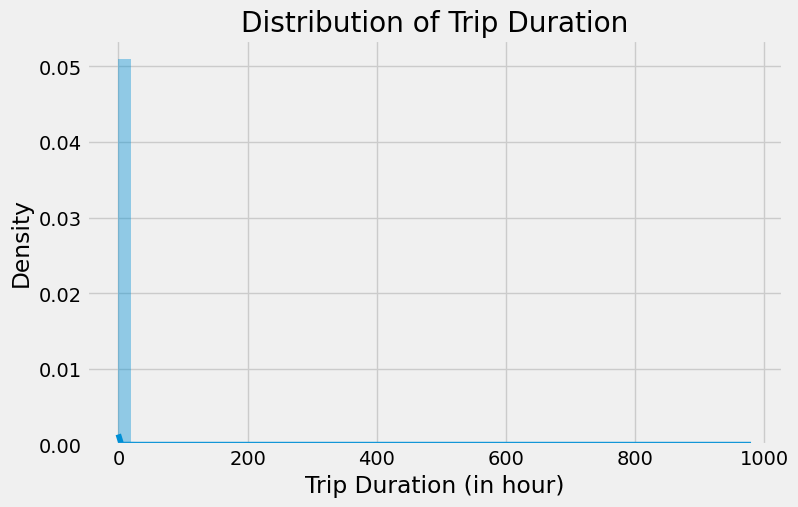

In [18]:
plt.figure(figsize = (8, 5))
sns.distplot(train['trip_duration_in_hour']).set_title("Distribution of Trip Duration")
plt.xlabel("Trip Duration (in hour)")
plt.show()

There are trip duration greater than 24 hours. We will have to investigate this.

In [19]:
outlier_trip_duration = train.loc[train['trip_duration_in_hour'] > 24]
outlier_trip_duration

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoof_latitude_round3,dropoff_longitude_round3,trip_distance,trip_duration_in_hour
355003,id1864733,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.789650,40.643559,-73.956810,40.773087,N,...,2016-01-27,27,11,Wednesday,40.644,-73.790,40.773,-73.957,20.154989,538.815556
680594,id0369307,1,2016-02-13 22:38:00,2016-03-08 15:57:38,2,-73.921677,40.735252,-73.984749,40.759979,N,...,2016-03-08,8,15,Tuesday,40.735,-73.922,40.760,-73.985,5.984365,569.327222
924150,id1325766,1,2016-01-05 06:14:15,2016-01-31 01:01:07,1,-73.983788,40.742325,-73.985489,40.727676,N,...,2016-01-31,31,1,Sunday,40.742,-73.984,40.728,-73.985,1.635641,618.781111
978383,id0053347,1,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.783905,40.648632,-73.978271,40.750202,N,...,2016-03-25,25,18,Friday,40.649,-73.784,40.750,-73.978,19.906909,979.522778


There are 4 records which have very high trip duration, but the distance traveled is very low. These are outliers. But is there any particular location to which these trips begin or end? Trip duration is also skewed, so let us take log transformation.

We will not remove these from the analysis, because they might be a part of test data as well.

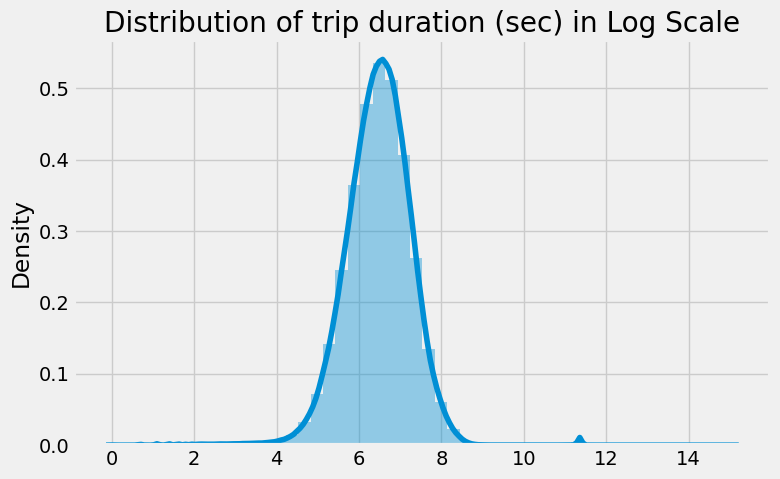

In [20]:
plt.figure(figsize = (8, 5))
sns.distplot(np.log(train['trip_duration'].values)).set_title("Distribution of Trip Duration")
plt.title("Distribution of trip duration (sec) in Log Scale")
plt.show()

Log transformation of the trip duration results in a normal distribution. Most trips are between 54 sec (exp(4)) and 2980 sec(exp(8)). This indicates that most trip are withing one hour. But, there are trips which are less than a minute and need to be explored in detail. There are trips lasting for 100 hours which is weird as the taxi rides are whithin New York.

#### Heatmap of common locations from where pickup and dropoff occurs

In [63]:
pickup = pd.DataFrame(train.groupby(['pickup_latitude_round3', 'pickup_longitude_round3'])['id'].count()).reset_index().rename(columns = {'id':'Num_Trips'})

In [66]:
pickup = pickup.astype({'Num_Trips':'float'})

In [67]:
pickup_map = folium.Map(location = [40.730610,-73.935242],zoom_start = 10)

hm_wide = HeatMap( list(zip(pickup.pickup_latitude_round3.values, pickup.pickup_longitude_round3.values, pickup.Num_Trips.values)),
                     min_opacity=0.2,
                     radius=5, blur=15,
                     max_zoom=1
                 )
pickup_map.add_child(hm_wide)

pickup_map

(-74.03, -73.75)

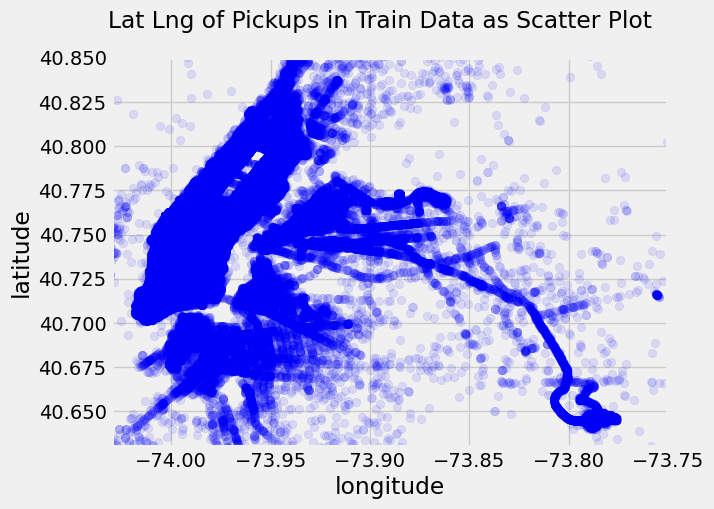

In [37]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols = 1, sharex = True, sharey = True)
ax.scatter(train['pickup_longitude'], train['pickup_latitude'], color = 'blue', label = 'train', alpha = 0.1)
fig.suptitle('Lat Lng of Pickups in Train Data as Scatter Plot')

ax.set_ylabel('latitude')
ax.set_xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)

***This graph clearly shows heavy density of pickups near JFK.***

In [49]:
drop=train.groupby(['dropoff_latitude_round3','dropoff_longitude_round3'])['id'].count().reset_index().rename(columns={'id':'Num_Trips'})

In [58]:
drop = drop.astype({'Num_Trips': 'float'})

In [60]:
drop_map = folium.Map(location = [40.730610,-73.935242],zoom_start = 10,)


hm_wide = HeatMap( list(zip(drop.dropoff_latitude_round3.values, drop.dropoff_longitude_round3.values, drop.Num_Trips.values)),
                     min_opacity=0.2,
                     radius=5, blur=15,
                     max_zoom=1
                 )
drop_map.add_child(hm_wide)
drop_map

#### Heatmap of trip duration, when pickup originates from a point

In [51]:
pickup = train.groupby(['pickup_latitude_round3', 'pickup_longitude_round3'])['trip_duration'].mean().reset_index().rename(columns = {'trip_duration': 'Avg_Trip_duration'})

In [52]:
pickup_map = folium.Map(location = [40.730610,-73.935242],zoom_start = 10,)


hm_wide = HeatMap( list(zip(pickup.pickup_latitude_round3.values, pickup.pickup_longitude_round3.values, pickup.Avg_Trip_duration.values)),
                     min_opacity=0.2,
                     radius=7, blur=15,
                     max_zoom=1
                 )
pickup_map.add_child(hm_wide)
pickup_map

The average trip duration, when trip originates from JFK is higher. If we zoom in, we can see that after the Manhattan. The pickups from JFK tend to have higher trip duration.

#### Which hours are pickup and dropoff higher?

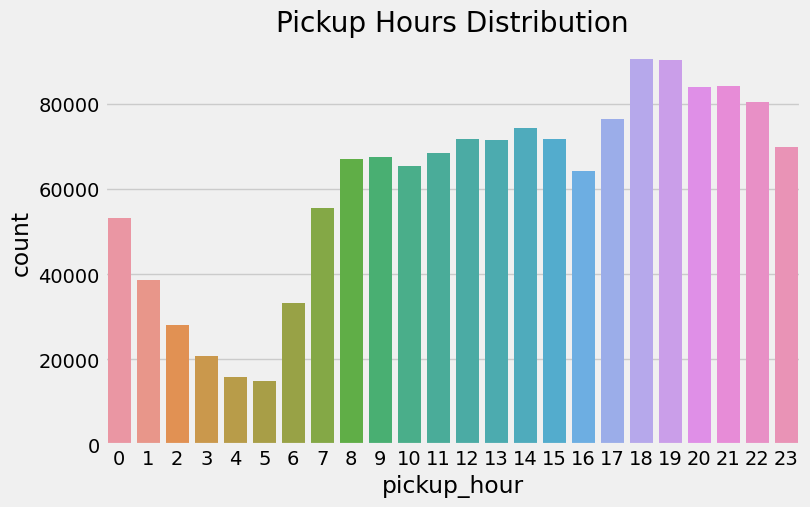

In [68]:
plt.figure(figsize = (8, 5))
sns.countplot(x = train['pickup_hour']).set_title('Pickup Hours Distribution')
plt.show()

The pickups are much lower in the early mornings. Most pickips are around highest between 6 to 8pm.

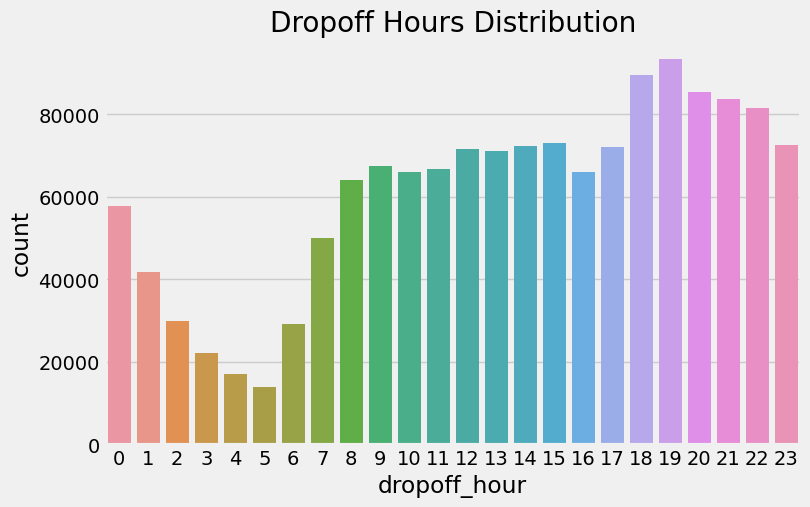

In [71]:
plt.figure(figsize = (8,5))
sns.countplot(x = train['dropoff_hour']).set_title("Dropoff Hours Distribution")
plt.show()

Distribution of dropoff hour very similar to pickup hour.

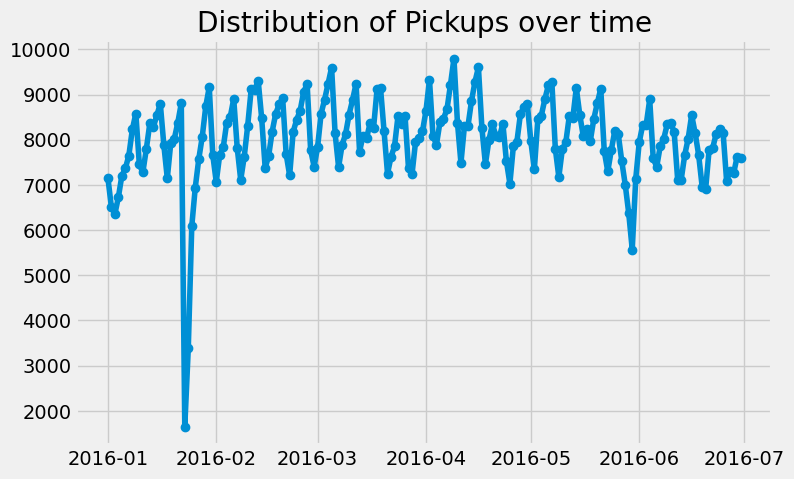

In [72]:
plt.figure(figsize = (8, 5))
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label = 'train')
plt.title("Distribution of Pickups over time")
plt.show()

There is a drop seen in the number of pick ups in end the January 2016.

#### What is the distribution of Trip distance

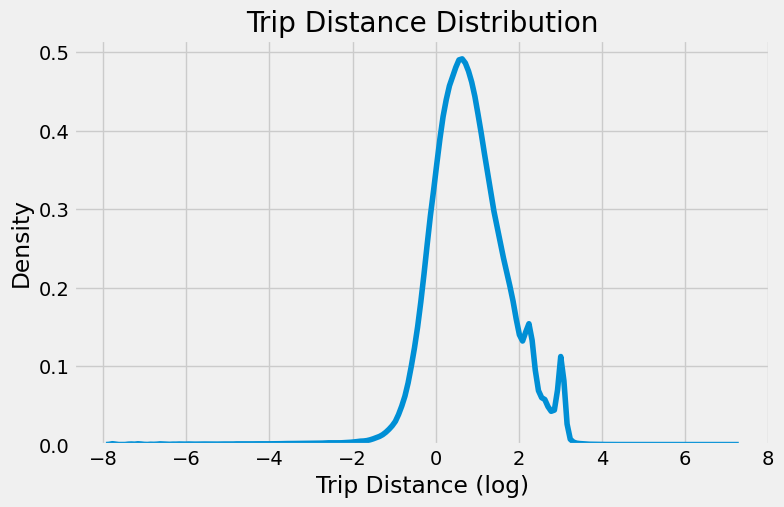

In [73]:
plt.figure(figsize = (8, 5))
sns.kdeplot(np.log(train['trip_distance'].values)).set_title("Trip Distance Distribution")
plt.xlabel("Trip Distance (log)")

plt.show()